This notebook is used for SI 650 Information Retrieval class. You should implement retrieval functions and report corresponding results in your submission on Canvas. 


In [1]:
# install metapy, it may take several minutes.
!pip install metapy
import metapy
import __future__

In [2]:
# Reading Data
!wget -nc https://raw.githubusercontent.com/meta-toolkit/meta/master/data/lemur-stopwords.txt
!wget -N https://meta-toolkit.org/data/2016-11-10/cranfield.tar.gz
!tar xf cranfield.tar.gz

File ‘lemur-stopwords.txt’ already there; not retrieving.

--2018-10-08 18:05:18--  https://meta-toolkit.org/data/2016-11-10/cranfield.tar.gz
Resolving meta-toolkit.org (meta-toolkit.org)... 50.116.41.177
Connecting to meta-toolkit.org (meta-toolkit.org)|50.116.41.177|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘cranfield.tar.gz’ not modified on server. Omitting download.



In [3]:
# Setting dataset
with open('cranfield/tutorial.toml', 'w') as f:
    f.write('type = "line-corpus"\n')
    f.write('store-full-text = true\n')

config = """prefix = "." # tells MeTA where to search for datasets

dataset = "cranfield" # a subfolder under the prefix directory
corpus = "tutorial.toml" # a configuration file for the corpus specifying its format & additional args

index = "cranfield-idx" # subfolder of the current working directory to place index files

query-judgements = "cranfield/cranfield-qrels.txt" # file containing the relevance judgments for this dataset

stop-words = "lemur-stopwords.txt"

[[analyzers]]
method = "ngram-word"
ngram = 1
filter = "default-unigram-chain"
"""
with open('cranfield-config.toml', 'w') as f:
    f.write(config)

# **1. Build Retrieval Function**

In [4]:
# Make sure you have installed metapy package and downloaded the data before running the following code

In [5]:
# Build the index for dataset.
inv_idx = metapy.index.make_inverted_index('cranfield-config.toml')

In [6]:
class  SimpleRanker (metapy.index.RankingFunction):                                            
                                                                       
    def __init__(self, some_param=1.0):                                             
        self.param = some_param
        super(SimpleRanker, self).__init__()                                        
                                                                                 
    def score_one(self, sd):
        return (self.param + sd.doc_term_count) / (self.param * sd.doc_unique_terms + sd.doc_size)

**Add your answer in the cells below:**

In [7]:
import math
class Pivoted(metapy.index.RankingFunction):                                                                                                                    
    def __init__(self, s = 0.1):                                             
        self.s = s
        # You *must* invoke the base class __init__() here!
        super(Pivoted, self).__init__()                                        
                                                                                 
    def score_one(self, sd):
        """
        You need to override this function to return a score for a single term.
        
        You may want to call some of the following variables when implementing your retrieval function:
        
        
        sd.avg_dl: average document length of the collection
        sd.num_docs: total number of documents in the index
        sd.total_terms: total number of terms in the index
        sd.query_length: the total length of the current query (sum of all term weights)
        sd.query_term_weight: query term count (or weight in case of feedback)
        sd.doc_count: number of documents that a term t_id appears in
        sd.corpus_term_count: number of times a term t_id appears in the collection
        sd.doc_term_count: number of times the term appears in the current document
        sd.doc_size: total number of terms in the current document
        sd.doc_unique_terms: number of unique terms in the current document
        
        """
        
        s = self.s      
        #Fill your answers here
        IDF =  (sd.num_docs+1) / sd.doc_count 
        Nor_TF = (1 + math.log(1+math.log(sd.doc_term_count))) / (1-s +s *sd.total_terms/sd.avg_dl)
        TF = sd.corpus_term_count
        
        return math.log(IDF*Nor_TF*TF)

In [8]:
import math

class BM25(metapy.index.RankingFunction):                                            
    """                                                                          
    Create a new ranking function in Python that can be used in MeTA.             
    """                                                                          
    def __init__(self, k1 = 1.2, b = 0.75, k3 = 500):                                             
        self.k1 = k1
        self.b = b
        self.k3 = k3
        # You *must* invoke the base class __init__() here!
        super(BM25, self).__init__()                                        
                                                                                 
    def score_one(self, sd):
        """
        You need to override this function to return a score for a single term.
        
        You may want to call some of the following variables when implementing your retrieval function:
        
        sd.avg_dl: average document length of the collection
        sd.num_docs: total number of documents in the index
        sd.total_terms: total number of terms in the index
        sd.query_length: the total length of the current query (sum of all term weights)
        sd.query_term_weight: query term count (or weight in case of feedback)
        sd.doc_count: number of documents that a term t_id appears in
        sd.corpus_term_count: number of times a term t_id appears in the collection
        sd.doc_term_count: number of times the term appears in the current document
        sd.doc_size: total number of terms in the current document
        sd.doc_unique_terms: number of unique terms in the current document
        
        """
        k1 = self.k1
        b = self.b
        k3 = self.k3
        
        #Fill your answer here
        
        V_IDF = (sd.num_docs - sd.doc_count + 0.5) /(sd.doc_count + 0.5)
        N_TF = (k1+1)* sd.doc_term_count / (k1*(1-b+b*sd.total_terms/sd.avg_dl) + sd.doc_term_count)
        QTF = (k3+1)*sd.corpus_term_count / (k3 + sd.corpus_term_count)
        return math.log(V_IDF * N_TF * QTF)

In [9]:
# We currently use the simple ranker here. Please change it to Pivoted Ranker after you implement it.
# ranker = SimpleRanker()
#ranker = Pivoted()   
ranker = BM25(0.7) 

# **2 Evaluate Retrieval Function**

In [10]:
ev = metapy.index.IREval('cranfield-config.toml')

In [ ]:
# Evaluate top 30 search results for cranfield dataset
num_results = 30

precision_list = []
with open('cranfield/cranfield-queries.txt') as query_file:
    for query_num, line in enumerate(query_file):
        query = metapy.index.Document()
        query.content(line.strip())
        results = ranker.score(inv_idx, query, num_results)                            
        avg_p = ev.avg_p(results, query_num + 1, num_results)
        precision_list.append(ev.precision(results,query_num+1,num_results))
        

In [96]:
# Print Ranking Performance
print "MAP:", ev.map()
print "Precison@30",sum(precision_list) / len(precision_list)

MAP: 0.243207891444
Precison@30 0.110074074074


In [93]:
ranker = BM25(b= 0.8) 

**Add your answer in the cells below:**


In [0]:
# Evaluate different settings for Pivoted and BM25.


Please draw plots to report the results of parameter tuning for Pivoted and BM25.

In [112]:
from matplotlib import pyplot as plt
BM25_list = []
Pivoted_list = []
index_list = []
for i in range(1,10):
    # Pivoted
    ranker = Pivoted(0.1*i) 
    index_list.append(0.1*i)
    ev = metapy.index.IREval('cranfield-config.toml')
    # Evaluate top 30 search results for cranfield dataset
    num_results = 30
    with open('cranfield/cranfield-queries.txt') as query_file:
        for query_num, line in enumerate(query_file):
            query = metapy.index.Document()
            query.content(line.strip())
            results = ranker.score(inv_idx, query, num_results)                            
            avg_p = ev.avg_p(results, query_num + 1, num_results)
            precision_list.append(ev.precision(results,query_num+1,num_results))
    Pivoted_list.append(ev.map())
    # BM25
    ranker = BM25(b = 0.1*i)
    ev = metapy.index.IREval('cranfield-config.toml')
    # Evaluate top 30 search results for cranfield dataset
    num_results = 30
    with open('cranfield/cranfield-queries.txt') as query_file:
        for query_num, line in enumerate(query_file):
            query = metapy.index.Document()
            query.content(line.strip())
            results = ranker.score(inv_idx, query, num_results)                            
            avg_p = ev.avg_p(results, query_num + 1, num_results)
            precision_list.append(ev.precision(results,query_num+1,num_results))
    BM25_list.append(ev.map())


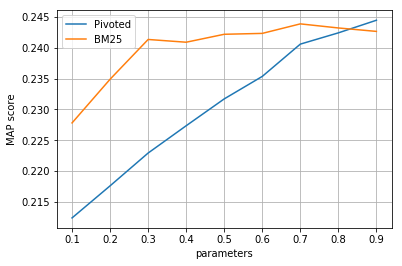

Pivoted[0.21238305103037858, 0.2175902706362351, 0.2229121125896805, 0.22734155118542365, 0.23169769307507965, 0.23534602411256075, 0.2405853155823801, 0.24241406744259145, 0.2444605999175258]
BM25[0.22779768088695365, 0.2348880374041246, 0.24134106556798465, 0.24089455717230215, 0.24218315301991278, 0.24232651926805812, 0.24387140499265503, 0.24320789144366314, 0.24265017076688658]


In [113]:
plt.figure()
plt.plot(index_list,Pivoted_list)
plt.xlabel('parameters')
plt.ylabel('MAP score')
plt.plot(index_list,BM25_list)
plt.legend(['Pivoted','BM25'])
plt.grid()
plt.show()
print("Pivoted"+str(Pivoted_list))
print("BM25"+str(BM25_list))

# Testing Search Results for a Single Query

In [78]:
query = metapy.index.Document()
query.content("fluid")
top_docs = ranker.score(inv_idx, query, num_results=5)

In [79]:
for num, (d_id, _) in enumerate(top_docs):
    content = inv_idx.metadata(d_id).get('content')
    print("{}. {}...\n".format(num + 1, content))

1. turbulent boundary layer in compressible fluids . the continuity, momentum, and energy differential equations for turbulent flow of a compressible fluid are derived, and the apparent turbulent stresses and dissipation function are identified .  a general formula for skin friction, including heat transfer to a flat plate, is developed for a thin turbulent boundary layer in compressible fluids with zero pressure gradient .  curves are presented giving skin-friction coefficients and heat-transfer coefficients for air for various wall-to-free-stream temperature ratios and free-stream mach numbers . in the special case when the boundary layer is insulated, this general formula yields skin-friction coefficients higher than those given by the von karman wall-property compressible-fluid formula but lower than those given by the von karman incompressible-fluid formula .  heat transfer from the boundary layer to the plate generally increases the friction and heat-transfer coefficients ....

2

**Please submit your code for Pivoted and BM25 class to canvas. We need your code to verify your results.**